# MusicoSet Metadata Cleaning

Clean tab-separated musicoset files - convert `-` and `[]` to NA, trim whitespace

In [55]:
library(tidyverse)
library(readr)

In [56]:
# load artists
artists_in <- '../../data/musicoset_metadata/artists.csv'
songs_in <- '../../data/musicoset_metadata/songs.csv'
artists_out <- '../../data/cleaned/musicoset_artists_cleaned.csv'
songs_out <- '../../data/cleaned/musicoset_songs_cleaned.csv'

artists <- read_delim(artists_in, delim="\t", na=c("", "NA", "-"))
sprintf("%d artists loaded", nrow(artists))

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 11518 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (6): artist_id, name, artist_type, main_genre, genres, image_url
dbl (2): followers, popularity

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "11518 artists loaded"

In [57]:
glimpse(artists)

Rows: 11,518
Columns: 8
$ artist_id   <chr> "66CXWjxzNUsdJxJ2JdwvnR", "26VFTg2z8YR0cCuwLzESi2", "0Y5tJ~
$ name        <chr> "Ariana Grande", "Halsey", "Travis Scott", "Post Malone", ~
$ followers   <dbl> 34554242, 7368242, 6313709, 16737002, 483032, 15566666, 37~
$ popularity  <dbl> 96, 90, 94, 96, 89, 91, 85, 88, 81, 89, 86, 90, 88, 62, 55~
$ artist_type <chr> "singer", "singer", "rapper", "rapper", "singer", "DJ", "b~
$ main_genre  <chr> "dance pop", "dance pop", "pop", "dfw rap", "trap music", ~
$ genres      <chr> "['dance pop', 'pop', 'post-teen pop']", "['dance pop', 'e~
$ image_url   <chr> "https://i.scdn.co/image/b1dfbe843b0b9f54ab2e588f33e7637d2~


In [58]:
# load songs
songs <- read_delim(songs_in, delim="\t", na=c("", "NA", "-"))
sprintf("%d songs loaded", nrow(songs))

Rows: 20405 Columns: 7
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (5): song_id, song_name, billboard, artists, song_type
dbl (1): popularity
lgl (1): explicit

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "20405 songs loaded"

In [59]:
glimpse(songs)

Rows: 20,405
Columns: 7
$ song_id    <chr> "3e9HZxeyfWwjeyPAMmWSSQ", "5p7ujcrUXASCNwRaWNHR1C", "2xLMif~
$ song_name  <chr> "thank u, next", "Without Me", "SICKO MODE", "Sunflower - S~
$ billboard  <chr> "('Thank U, Next', 'Ariana Grande')", "('Without Me', 'Hals~
$ artists    <chr> "{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'}", "{'26VFTg2z8~
$ popularity <dbl> 86, 87, 85, 92, 86, 63, 52, 53, 3, 51, 81, 48, 78, 77, 86, ~
$ explicit   <lgl> TRUE, TRUE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE,~
$ song_type  <chr> "Solo", "Solo", "Solo", "Collaboration", "Solo", "Solo", "S~


In [60]:
# clean artists - trim and fix dashes/empty lists
fix_dash <- function(x) {
  if(is.character(x)) {
    x <- ifelse(str_detect(x, "^-$"), NA_character_, x)
    x <- ifelse(str_detect(x, "^\\[\\]$"), NA_character_, x)
    x
  } else x
}

artists2 <- artists %>% 
  mutate(across(where(is.character), str_trim)) %>%
  mutate(across(where(is.character), fix_dash))

sprintf("Cleaned %d artists", nrow(artists2))

[1] "Cleaned 11518 artists"

In [61]:
# missing data both - []
artists2 %>% 
  summarise(across(everything(), ~sum(is.na(.)))) %>% 
  pivot_longer(everything()) %>%
  arrange(desc(value))

name,value
<chr>,<int>
artist_type,4466
main_genre,3148
genres,3148
image_url,504
followers,2
artist_id,0
name,0
popularity,0


In [62]:
# verify no standalone dashes or empty brackets
check <- artists2 %>% filter(if_any(where(is.character), ~ . == "-" | . == "[]"))
if(nrow(check) == 0) print("✓ No dashes or []")

[1] "<U+2713> No dashes or []"


In [63]:
# clean songs
songs2 <- songs %>% 
  mutate(across(where(is.character), str_trim)) %>%
  mutate(across(where(is.character), fix_dash))

sprintf("Cleaned %d songs", nrow(songs2))

[1] "Cleaned 20405 songs"

In [64]:
# song type breakdown
songs2 %>% count(song_type, sort=T)

song_type,n
<chr>,<int>
Solo,18978
Collaboration,1427


In [65]:
# export
dir.create("../../data/cleaned", showWarnings=F, recursive=T)

write_csv(artists2, artists_out, na="", quote="needed")
write_csv(songs2, songs_out, na="", quote="needed")

sprintf("Wrote artists: %s", artists_out)
sprintf("Wrote songs: %s", songs_out)

[1] "Wrote artists: ../../data/cleaned/musicoset_artists_cleaned.csv"

[1] "Wrote songs: ../../data/cleaned/musicoset_songs_cleaned.csv"

In [66]:
# verify files
a_lines <- length(readLines(artists_out))
s_lines <- length(readLines(songs_out))

sprintf("Artists: %d lines (expected %d)", a_lines, nrow(artists2)+1)
sprintf("Songs: %d lines (expected %d)", s_lines, nrow(songs2)+1)

[1] "Artists: 11519 lines (expected 11519)"

[1] "Songs: 20406 lines (expected 20406)"

In [67]:
# preview artists output
artists2 %>% 
  select(name, followers, popularity, artist_type, main_genre) %>%
  head(10)

name,followers,popularity,artist_type,main_genre
<chr>,<dbl>,<dbl>,<chr>,<chr>
Ariana Grande,34554242,96,singer,dance pop
Halsey,7368242,90,singer,dance pop
Travis Scott,6313709,94,rapper,pop
Post Malone,16737002,96,rapper,dfw rap
Swae Lee,483032,89,singer,trap music
Marshmello,15566666,91,DJ,brostep
Bastille,3776115,85,band,metropopolis
Panic! At The Disco,7749228,88,band,baroque pop
Mariah Carey,4682308,81,singer,dance pop


In [68]:
# preview songs output  
songs2 %>%
  select(song_name, billboard, popularity, explicit, song_type) %>%
  head(10)

song_name,billboard,popularity,explicit,song_type
<chr>,<chr>,<dbl>,<lgl>,<chr>
"thank u, next","('Thank U, Next', 'Ariana Grande')",86,TRUE,Solo
Without Me,"('Without Me', 'Halsey')",87,TRUE,Solo
SICKO MODE,"('Sicko Mode', 'Travis Scott')",85,TRUE,Solo
Sunflower - Spider-Man: Into the Spider-Verse,"('Sunflower (Spider-Man: Into The Spider-Verse)', 'Post Malone & Swae Lee')",92,FALSE,Collaboration
High Hopes,"('High Hopes', 'Panic! At The Disco')",86,FALSE,Solo
All I Want for Christmas Is You,"('All I Want For Christmas Is You', 'Mariah Carey')",63,FALSE,Solo
It's the Most Wonderful Time of the Year,"(""It's The Most Wonderful Time Of The Year"", 'Andy Williams')",52,FALSE,Solo
Rockin' Around The Christmas Tree,"(""Rockin' Around The Christmas Tree"", 'Brenda Lee')",53,FALSE,Solo
A Holly Jolly Christmas,"('A Holly Jolly Christmas', 'Burl Ives')",3,FALSE,Solo


## Lyrics Dataset Cleaning and Analysis

Load, clean, and analyze the lyrics dataset from musicoset_songfeatures

In [69]:
# Load lyrics dataset
lyrics_in <- '../../data/musicoset_songfeatures/lyrics.csv'
lyrics_out <- '../../data/cleaned/musicoset_lyrics_cleaned.csv'

lyrics <- read_delim(lyrics_in, delim="\t", show_col_types = FALSE)
sprintf("Loaded %d lyrics", nrow(lyrics))

[1] "Loaded 20404 lyrics"

In [70]:
glimpse(lyrics)

Rows: 20,404
Columns: 2
$ song_id <chr> "3e9HZxeyfWwjeyPAMmWSSQ", "5p7ujcrUXASCNwRaWNHR1C", "2xLMifQCj~
$ lyrics  <chr> "['[Verse 1]\\nThought I\\'d end up with Sean\\nBut he wasn\\'~


In [71]:
# Clean lyrics - remove newlines and normalize whitespace
lyrics2 <- lyrics %>% 
  mutate(across(where(is.character), function(x) {
    x <- str_replace_all(x, "\\n", " ")
    x <- str_replace_all(x, "\\r", "")
    x <- str_replace_all(x, "\\s+", " ")
    str_trim(x)
  }))

sprintf("Cleaned %d lyrics", nrow(lyrics2))

[1] "Cleaned 20404 lyrics"

In [72]:
# Verify no newlines remain
check_newlines <- lyrics2 %>% filter(str_detect(lyrics, "\\n"))
if(nrow(check_newlines) == 0) {
  print("✓ No newlines in lyrics")
}

[1] "<U+2713> No newlines in lyrics"


In [73]:
# Export cleaned lyrics
write_csv(lyrics2, lyrics_out, na="", quote="all", eol="\n")
sprintf("Wrote: %s", lyrics_out)

[1] "Wrote: ../../data/cleaned/musicoset_lyrics_cleaned.csv"

### Song Length Analysis

Check for songs that are unusually short (<100 words) or long (>600 words)

In [74]:
# Count words in lyrics
lyrics_word_count <- lyrics2 %>%
  filter(!is.na(lyrics)) %>%
  mutate(
    word_count = str_count(lyrics, "\\S+"),  # Count non-whitespace sequences
    length_category = case_when(
      word_count < 100 ~ "Too Short (<100)",
      word_count > 600 ~ "Too Long (>600)",
      TRUE ~ "Normal (100-600)"
    )
  )

# Summary statistics
summary(lyrics_word_count$word_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     169     235    1251     349  148724 

In [75]:
# Count songs by length category
lyrics_word_count %>%
  count(length_category) %>%
  mutate(percentage = round(n / sum(n) * 100, 2)) %>%
  arrange(desc(n))

length_category,n,percentage
<chr>,<int>,<dbl>
Normal (100-600),16810,85.49
Too Long (>600),1985,10.10
Too Short (<100),868,4.41


In [76]:
# Show songs that are too short (metadata only, no lyrics)
print("=== Songs with < 100 words ===")
lyrics_word_count %>%
  filter(length_category == "Too Short (<100)") %>%
  select(song_id, word_count) %>%
  arrange(word_count) %>%
  head(10)

[1] "=== Songs with < 100 words ==="


song_id,word_count
<chr>,<int>
4zW7Titqo6iTdhtIl8T3RG,1
0GhuwiwcAuw3zU5QHCmBiP,1
7qLalcfiXPHYy1pVK23B5J,1
2YpjoEkXlkT5TBM2T7Hzkh,1
4wtR6HB3XekEengMX17cpc,1
2EsOy9Yk7Du8RvkA0lhm4L,1
1TUtUzVjXu1zA4U9nNv3Pw,1
4bMNm9BVDw5wuw86hpwCij,1
5imGt4mmqSXwRyHOkdiVaf,1


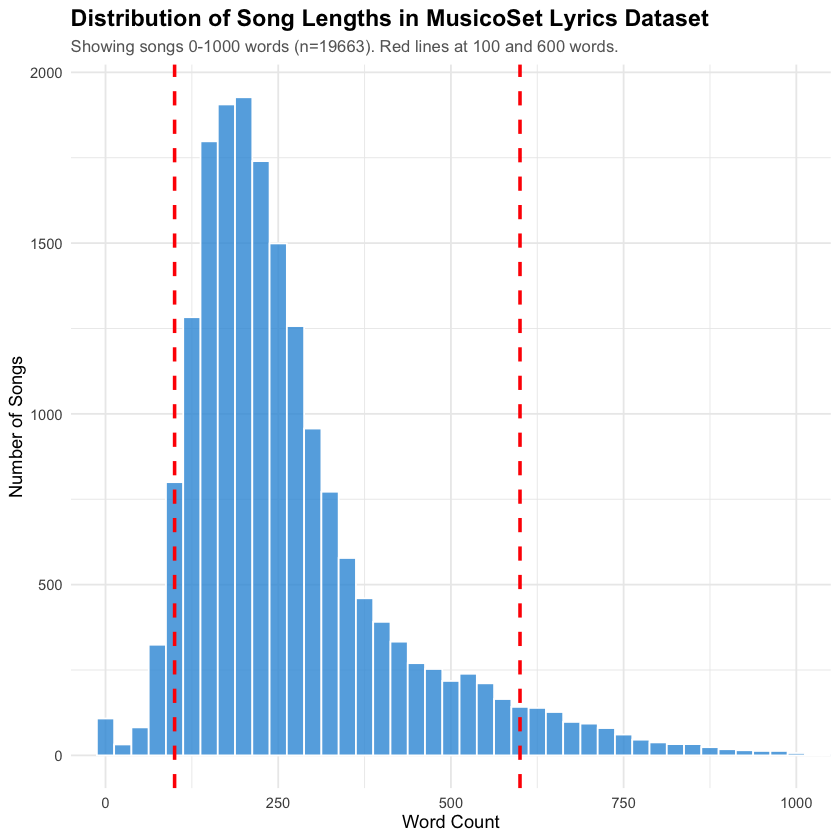

In [77]:
# Visualization: Word count distribution (limited to 0-1000 for clarity)
library(ggplot2)

ggplot(lyrics_word_count, aes(x = word_count)) +
  geom_histogram(binwidth = 25, fill = "#3498DB", color = "white", alpha = 0.8) +
  geom_vline(xintercept = 100, linetype = "dashed", color = "red", linewidth = 1) +
  geom_vline(xintercept = 600, linetype = "dashed", color = "red", linewidth = 1) +
  coord_cartesian(xlim = c(0, 1000)) +  # Limit x-axis to show data clearly
  labs(
    title = "Distribution of Song Lengths in MusicoSet Lyrics Dataset",
    subtitle = sprintf("Showing songs 0-1000 words (n=%d). Red lines at 100 and 600 words.", nrow(lyrics_word_count)),
    x = "Word Count",
    y = "Number of Songs"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    plot.subtitle = element_text(size = 10, color = "gray40")
  )

ggsave("../../data/cleaned/musicoset_song_length_distribution.png", width = 10, height = 6, dpi = 300)